# Roots En Wikivoyage

https://huggingface.co/datasets/bigscience-data/roots_en_wikivoyage

## Imports

In [1]:
from dotenv import load_dotenv
import os

load_dotenv() # take environment variables from .env.

True

In [2]:
import ast

import pandas as pd
import requests
import numpy as np
from datasets import load_dataset
from huggingface_hub import login
from mistralai import Mistral
import json
import matplotlib.pyplot as plt
import seaborn as sns

/Users/vasilisa/miniconda3/envs/llm_dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sns.set_style("whitegrid")

In [4]:
token = os.getenv("HUGGING_FACE")
api_key = os.getenv("MISTRAL_API_KEY")

In [5]:
login(token=token)

In [6]:
output_fpath = "output_data"
if not os.path.exists(output_fpath):
    os.mkdir(output_fpath)

In [7]:
figures_fpath = "figures"
if not os.path.exists(figures_fpath):
    os.mkdir(figures_fpath)

## Loading dataset

In [8]:
dataset = load_dataset("bigscience-data/roots_en_wikivoyage", split="train")

In [9]:
type(dataset)

datasets.arrow_dataset.Dataset

## EDA

### Base Structure

In [10]:
dataset

Dataset({
    features: ['meta', 'text'],
    num_rows: 24838
})

In [11]:
dataset[0]["text"][:100]

'This article describes routes that avoid a transit of the United States. Since the documentation req'

In [12]:
dataset[12]["text"][-1000:]

'ams Street. When you reach Wacker Drive, turn left around the Sears Tower and head into the main lobby. The Sears Tower likely needs no introduction, but the massive art installation inside is less well known. In the Heart of this Infinite Particle of Dust is the last of the day\'s sculptures, by Jacob Hashimoto. The cloud-like work is made up of 7,000 individual disks suspended from the ceiling, with varying lengths of string. Your tour ends here in the Sears Tower, and you might want to take this opportunity to ride the 20 miles per hour elevator to the Sears Tower Skydeck for some grand views of the journey you\'ve just taken. If you are thinking of dinner at this point, you are just a block away from the Quincy L station — you have your choice of neighborhoods to visit for dinner. Some especially good "ethnic" dining options not too far from the Loop are in Greektown a short walk across the river, Chinatown to the south (Red Line), and authentic Mexican cuisine in Pilsen (Pink Lin

In [13]:
all_meta = []
titles = []
languages = set()

In [14]:
ast.literal_eval(dataset[0]["meta"])

{'content_model': 'wikitext',
 'language': 'en',
 'title': 'Avoiding travel through the United States',
 'type': 'text'}

In [15]:
for data in dataset:
    all_meta.append(ast.literal_eval(data["meta"]))

In [16]:
for meta in all_meta:
    titles.append(meta["title"])
    languages.add(meta["language"])

In [17]:
languages

{'en'}

In [18]:
len(titles)

24838

In [19]:
titles[:5]

['Avoiding travel through the United States',
 'E1 Long Distance Path',
 'Ferries in the Caspian Sea',
 'Longobard sites',
 'Caribbean Nicaragua']

In [20]:
sorted(titles)[:10]

["'s-Hertogenbosch",
 '100 Mile House',
 '20th-century South Africa',
 '88 Temple Pilgrimage',
 'A Coruña',
 'A Taste of Coastal Texas',
 'A seaside stroll in Helsinki',
 'Aa en Hunze',
 'Aachen',
 'Aalborg']

In [21]:
titles[4]

'Caribbean Nicaragua'

In [22]:
len(dataset[4]["text"])

4101

In [23]:
df = pd.DataFrame({"title": titles})

In [24]:
df[df["title"].str.contains("Moscow")]

,title
24,Moscow/Central-South
48,Moscow/Outskirts
313,Moscow/Zelenograd and New Moscow
2049,West Moscow Oblast
3518,North Moscow Oblast
7453,Moscow/Central-West
7642,Moscow to Urumqi
16875,Moscow (Idaho)
18146,Moscow/Central-North
19382,Moscow/Central-East


In [25]:
len(dataset[23554]["text"])

67613

In [26]:
dataset[23554]["text"][:1100]

'For other places with the same name, see Moscow (disambiguation). Moscow is a huge city with several district articles that contain information about specific sights, restaurants, and accommodation. Since its founding in 1147, Moscow (Russian: Москва, Moskva) has been at the crossroads of history as the capital of empires and a frequent target for invaders. As the capital of the Russian Empire, the Soviet Union, and, today, the Russian Federation, it has played a central role in the development of the largest country in the world. For many, the sight of the Kremlin complex in the centre of the city is still loaded with symbolism and history. Today, Moscow is a thriving, exuberant capital city that overflows with life, culture and sometimes traffic. A sprawling metropolis, and among the largest cities on the European continent, Moscow is home to numerous museums, Soviet-era monoliths and post-Soviet kitsch, but continues to pave the way forward as Muscovites move into the 21st century.

In [27]:
dataset[23554]["text"][-1100:]

'eum, local history museum, art and history museum, etc. The monastery was founded in 1656 by Tzar Alexis II and Patriarch Nikon (his "cell", a three-storey house stands in the park outside the monastery walls) to resemble the original Jerusalem. 55.72836.81614 Savvino-Storozhevskiy monastery (Саввино-Сторожевский монастырь) (65 km (40 mi) W; Commuter trains from Belorussky station to Zvenigorod , several daily; travel time ~1 hr, 1.5 km (0.93 mi) west to monastery, which is on a nearby hill.). A beautiful monastery with interesting history, closely connected to Russian Tzars. 56.3537.53333315 Dmitrov (Дмитров) (65 km (40 mi) North from Moscow (trains from Savelovsky station, several daily, 11⁄2 hr)). A town, on Moscow Channel, with old churches, interesting sculptures in the streets and a number of museums  55.87858537.03591516 Snegiri (40 km (25 mi) NW from Moscow (Volokolamskoe hwy), trains from Rizhsky Station, several daily, travel time about an hour). - Settlement, that boasts a 

In [28]:
df.head()

,title
0,Avoiding travel through the United States
1,E1 Long Distance Path
2,Ferries in the Caspian Sea
3,Longobard sites
4,Caribbean Nicaragua


In [29]:
df = df.reset_index()

In [30]:
df.rename(columns={"index": "id"}, inplace=True)

In [31]:
df.to_csv(f"{output_fpath}/titles.csv", index=False)

## Links to pages

We assume that basic link to wikivoyage looks like this:

```
https://en.wikivoyage.org/wiki/North_America
```

In [32]:
def check_url(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
    }
    try:
        response = requests.get(url, headers=headers, stream=True, timeout=5)
        response.close()
        return response.status_code == 200
    except requests.RequestException:
        return False

In [33]:
titles[0].replace(" ", "_")

'Avoiding_travel_through_the_United_States'

In [34]:
title = titles[0].replace(" ", "_")

link_template = f"https://en.wikivoyage.org/wiki/{title}"
link_template

'https://en.wikivoyage.org/wiki/Avoiding_travel_through_the_United_States'

In [35]:
link_status = []

In [36]:
titles[:5]

['Avoiding travel through the United States',
 'E1 Long Distance Path',
 'Ferries in the Caspian Sea',
 'Longobard sites',
 'Caribbean Nicaragua']

In [37]:
for title in titles[:10]:
    url = f"https://en.wikivoyage.org/wiki/{title.replace(" ", "_")}"
    print(url)
    link_status.append(check_url(url))

https://en.wikivoyage.org/wiki/Avoiding_travel_through_the_United_States
https://en.wikivoyage.org/wiki/E1_Long_Distance_Path
https://en.wikivoyage.org/wiki/Ferries_in_the_Caspian_Sea
https://en.wikivoyage.org/wiki/Longobard_sites
https://en.wikivoyage.org/wiki/Caribbean_Nicaragua
https://en.wikivoyage.org/wiki/Home_exchange
https://en.wikivoyage.org/wiki/The_Most_Beautiful_Villages_of_France
https://en.wikivoyage.org/wiki/Driving_in_Denmark
https://en.wikivoyage.org/wiki/First_and_business_class_flights
https://en.wikivoyage.org/wiki/Attractions


In [38]:
link_status

[True, True, True, True, True, True, True, True, True, True]

### Saving sample to parquet

In [39]:
subset = dataset.select(range(50))

sample_fpath = (
    os.path.join(
        output_fpath,
        "roots_enwikivoyage_sample_50.parquet",
    )
)
subset.to_parquet(sample_fpath)

Creating parquet from Arrow format: 100%|████████| 1/1 [00:00<00:00, 147.85ba/s]


845799

In [40]:
df = pd.read_parquet(sample_fpath)

In [41]:
df.head()

,meta,text
0,"{'content_model': 'wikitext', 'language': 'en'...",This article describes routes that avoid a tra...
1,"{'content_model': 'wikitext', 'language': 'en'...",The E1 European Long Distance Path is one of t...
2,"{'content_model': 'wikitext', 'language': 'en'...",This page aims to provide an overview of all t...
3,"{'content_model': 'wikitext', 'language': 'en'...",Longobards in Italy. Places of the Power (568-...
4,"{'content_model': 'wikitext', 'language': 'en'...",Caribbean Nicaragua is a region in Nicaragua. ...


## Articles analysis

In [42]:
len(dataset["text"])

24838

In [43]:
total_len = 0
texts_len = []
for data in dataset:
    t_len = len(data["text"])
    total_len += t_len
    texts_len.append(t_len)

In [44]:
total_len

238513821

In [45]:
min(texts_len)

936

In [46]:
texts_len.index(936)

14564

In [47]:
dataset[14564]["meta"]

"{'content_model': 'wikitext', 'language': 'en', 'title': 'Ebino', 'type': 'text'}"

In [48]:
dataset[14564]["text"]

'Ebino (えびの) is a city in Miyazaki, Kyushu. The nearest airports are in Kagoshima (35 min by direct bus) and Miyazaki (transfer required). The Kitto Line (吉都線 Kitto-Sen) from Miyazaki (1 hour) makes stops in Ebino Īno (えびの飯野), Ebino Uwae (えびの上江), Ebino itself and Kyomachi Onsen (京町温泉). The Hisatsu Line (肥薩線 Hitatsu-sen) also stops at Masaki (真幸) station. Travel time from Fukuoka (via the Kyushu Shinkansen) is 5 hours, while Kagoshima is 2 hours away. Ebino is accessible via express and regular Miyakō Group (宮交グループ) [1] buses. Some buses may also stop in Iino (飯野). Ebino can be reached via the Kyūshū Expressway as well as national highway routes 221, 268, and 447. Kobayashi Transit (小林交通 Kobayashi Kōtsū) (0984-33-0154) Miwa Transit (三和交通 Kōtsū) (0984-33-0220) Miyakō Taxi (交通タクシー Miyakō Takushī) (0984-37-1351) A Transit (A交通 A Kōtsū) (0984-33-4300) Kobayashi Takaharu Miyakonojo Yusui Kirishima Hitoyoshi Nishiki Asagiri Kajiki'

In [49]:
max(texts_len)

279414

In [50]:
texts_len.index(279414)

6407

In [51]:
dataset[6407]["meta"]

"{'content_model': 'wikitext', 'language': 'en', 'title': 'Buffalo/East Side', 'type': 'text'}"

In [52]:
np.min(texts_len)

np.int64(936)

In [53]:
texts_len_dist = pd.DataFrame({"char_length_by_article": texts_len})

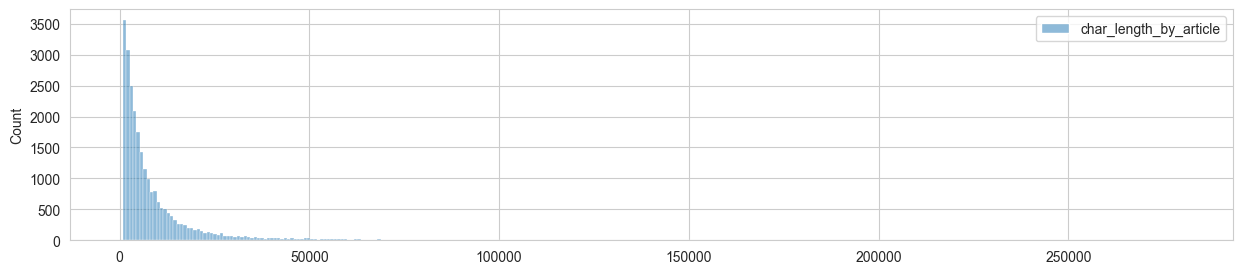

In [54]:
plt.figure(figsize=(15, 3))
sns.histplot(texts_len_dist)
plt.savefig(f"{figures_fpath}/char_length_dist_by_article.png")

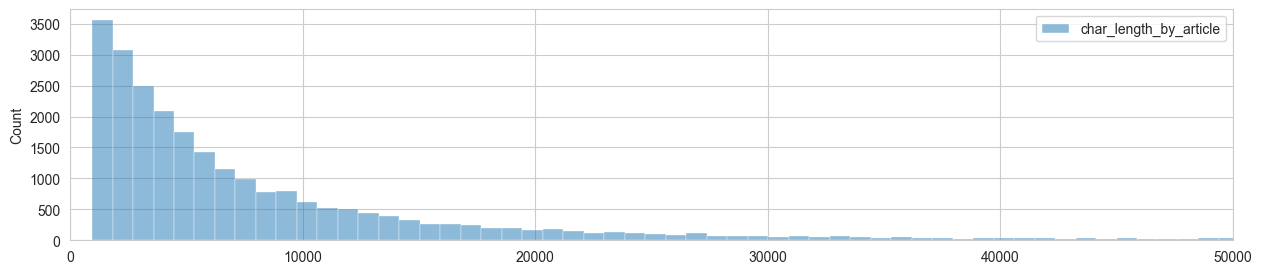

In [55]:
plt.figure(figsize=(15, 3))
sns.histplot(texts_len_dist)
plt.xlim(0, 50000)
plt.savefig(f"{figures_fpath}/char_length_dist_by_article_lim_50000.png")

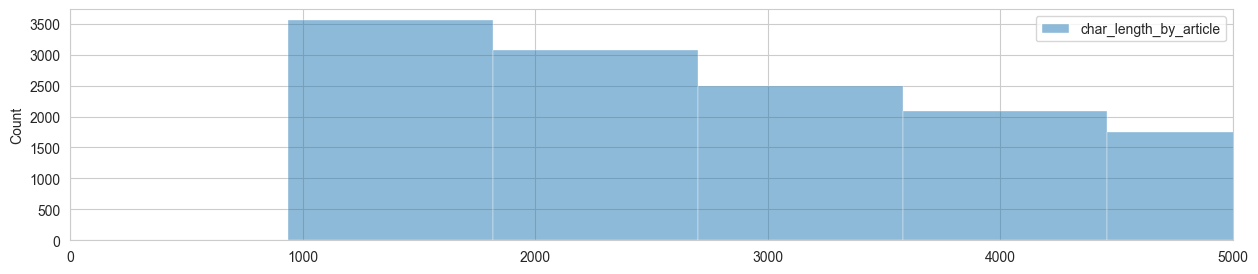

In [56]:
plt.figure(figsize=(15, 3))
sns.histplot(texts_len_dist)
plt.xlim(0, 5000)
plt.savefig(f"{figures_fpath}/char_length_dist_by_article_lim_5000.png")